In [1]:
import os
from pathlib import Path
from random import random
import shutil

def copy_file(source_directory, destination_directory, filename):
    destination_directory.mkdir(parents=True, exist_ok=True)
    shutil.copy(source_directory/filename, destination_directory/filename)

def organize_dataset(root_folder, valid_probability=0.1):
    for root, dirs, files in os.walk(root_folder/'original'):
        path = root.split(os.sep)
        if len(path)<3:
            continue

        label = path[2]
        for file in files:
            channel = Path('train') if random()>valid_probability else Path('test')
            source_directory = root_folder/'original'/label
            destination_directory = root_folder/channel/label
            copy_file(source_directory, destination_directory, file)

In [2]:
import zipfile

root = Path('data')
root.mkdir(exist_ok=True, parents=True)


if not (root/'original.zip').exists():
    print('Downloading dataset')
    !aws s3 cp s3://ch-workshop/data/original.zip data/original.zip

if not (root/'original').exists():
    print("Unzipping dataset")

    with zipfile.ZipFile(root/'original.zip', 'r') as zip_ref:
        zip_ref.extractall(root)

if not (root/'train').exists() and not (root/'test').exists():
    print("Creating train/test structure")
    organize_dataset(root)

In [22]:
import sagemaker

sagemaker_session = sagemaker.Session()

bucket = 'ch-workshop'
train_prefix = 'data/train'
test_prefix = 'data/test'

role = sagemaker.get_execution_role()

In [4]:
train_inputs = sagemaker_session.upload_data(path='data/train', bucket=bucket, key_prefix=train_prefix)
print('train input spec (in this case, just an S3 path): {}'.format(train_inputs))

test_inputs = sagemaker_session.upload_data(path='data/test', bucket=bucket, key_prefix=test_prefix)
print('train input spec (in this case, just an S3 path): {}'.format(train_inputs))

train input spec (in this case, just an S3 path): s3://ch-workshop/data/train
train input spec (in this case, just an S3 path): s3://ch-workshop/data/train


In [10]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(entry_point='train.py',
                    role=role,
                    py_version='py3',
                    framework_version='1.8.0',
                    instance_count=2,
                    instance_type='ml.p3.2xlarge',
                    hyperparameters={
                        'epochs': 100,
                        'backend': 'gloo'
                    })

In [11]:
estimator.fit({'training': train_inputs, 'testing': test_inputs})

In [23]:
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

# from sagemaker.predictor import Predictor
# from sagemaker.serializers import NumpySerializer
# from sagemaker.deserializers import NumpyDeserializer

# predictor = Predictor(endpoint_name='pytorch-training-2021-08-03-11-08-41-872', serializer=NumpySerializer(), deserializer=NumpyDeserializer())

In [61]:
from torchvision import transforms, datasets
import torch

test_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.6405, 0.6067, 0.5659], [0.2144, 0.2134, 0.2338])
    ])

test_dataset = datasets.ImageFolder(root/'test', transform=test_transforms)

test_dataloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=8,
        shuffle=True,
)

batch = next(iter(test_dataloader))[0]

In [65]:
response = predictor.predict(batch.numpy())
classes = [test_dataset.classes[i] for i in response.argmax(axis=1)]
print(f"Raw prediction result: {response}")

Raw prediction result:
[[11.60147285 -7.06273794 -2.96490145  0.89588737 -3.70710158  3.2101512 ]
 [-2.88754225  1.05354798  3.66559982 -5.06437969 10.30458641 -3.22214937]
 [-1.76984632 -1.89405942 -2.32412434  7.53397989 -0.14855552 -1.76485503]
 [-1.3016777  -3.26163292  8.02529621 -0.57937527  1.5331775   0.83478355]
 [10.35612392 -2.89794254 -3.23859739 -0.85247219 -3.64013934 -2.45103955]
 [-0.74966323 -1.445521   -2.81845832  5.08187485 -0.13975137 -0.25274926]
 [-0.76168865 -3.49651718 -6.35894203 10.86421299 -5.16095829  0.27081311]
 [-5.34191227  1.28525114 -0.26171237 -0.2406227   7.35429668  1.48915386]]



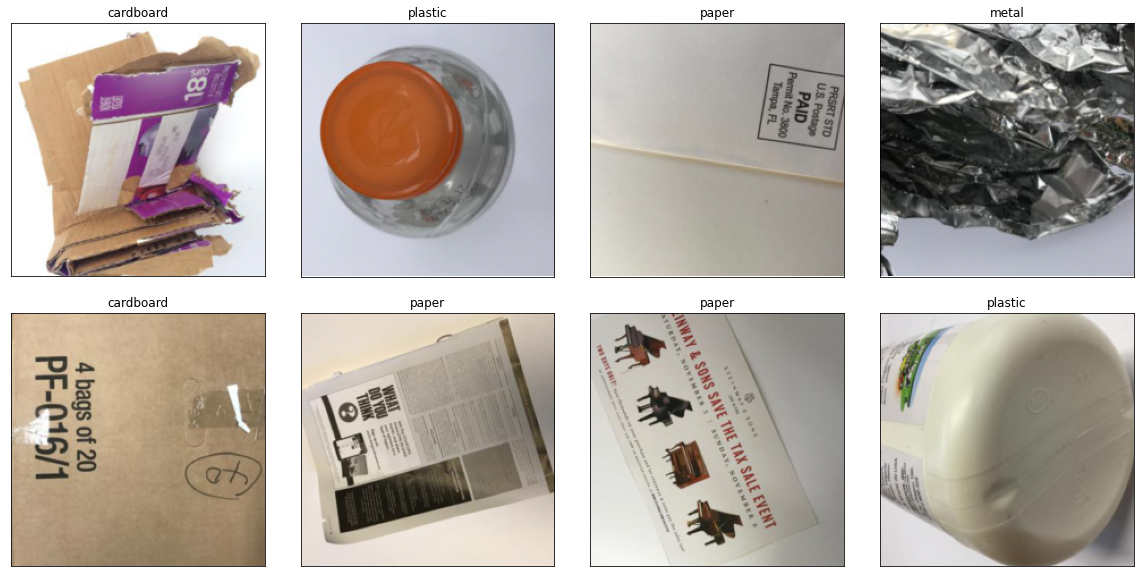

In [69]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

mean = torch.tensor([0.6405, 0.6067, 0.5659])
stdev = torch.tensor([0.2144, 0.2134, 0.2338])

def imshow(axis, inp, pred):
    inp = inp.permute(1,2,0)
    inp = inp * stdev + mean
    axis.imshow(inp)
    axis.get_xaxis().set_visible(False)
    axis.get_yaxis().set_visible(False)
    axis.set_title(pred)

fig = plt.figure(1, figsize=(30, 10))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 4), axes_pad=0.5)

for img, ax, pred in zip(batch, grid, classes):
    imshow(ax, img, pred)

In [ ]:
sagemaker_session.delete_endpoint(
    endpoint_name = predictor.endpoint_name
)